## Task Introduction
In the realm of traditional machine learning, constructing robust and meaningful features can substantially enhance the performance of the final model. Consequently, this notebook aims to showcase the capabilities of this package in automated feature construction. For the sake of simplicity, a problem from the scikit-learn package has been selected as the case study. This task, referred to as "diabetes," aims to predict a quantitative measure of disease progression one year after the baseline. Initially, the data is divided into training and testing sets, followed by the separate training of a random forest and an evolutionary forest. Finally, these models are tested on the testing set.


In [1]:
import sys
sys.path.insert(0, '../')

In [2]:
import random
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.datasets import load_diabetes
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

from evolutionary_forest.forest import EvolutionaryForestRegressor
from evolutionary_forest.utils import get_feature_importance, plot_feature_importance, feature_append

random.seed(0)
np.random.seed(0)

# Load dataset
X, y = load_diabetes(return_X_y=True)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
# Train Random Forest
r = RandomForestRegressor()
r.fit(x_train, y_train)
print(r2_score(y_test, r.predict(x_test)))

# Train Evolutionary Forest
r = EvolutionaryForestRegressor(max_height=5, normalize=True, select='AutomaticLexicase',
                                gene_num=10, boost_size=100, n_gen=20, n_pop=200, cross_pb=1,
                                base_learner='Random-DT', verbose=True, n_process=1)
r.fit(x_train, y_train)
print(r2_score(y_test, r.predict(x_test)))

0.26865181564422547
   	      	                                fitness                                 	                      size                     
   	      	------------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg     	gen	max     	min       	nevals	std     	avg  	gen	max	min	nevals	std    
0  	200   	0.185559	0  	0.646536	-0.0910032	200   	0.144012	42.47	0  	56 	30 	200   	5.43315
1  	200   	0.164686	1  	0.609552	-0.115303 	200   	0.136626	42.76	1  	56 	30 	200   	5.35373
2  	200   	0.16044 	2  	0.513479	-0.127493 	200   	0.132859	42.86	2  	56 	30 	200   	5.84298
3  	200   	0.137816	3  	0.568602	-0.0853714	200   	0.117792	43.28	3  	58 	30 	200   	6.35937
4  	200   	0.139747	4  	0.504311	-0.118973 	200   	0.119562	43.34	4  	58 	28 	200   	6.41595
5  	200   	0.131982	5  	0.682956	-0.162743 	200   	0.125599	44.59	5  	58 	28 	200   	6.47394
6  	200   	0.131857	6  	0.65887 	-0.131193 	200   	0.121311	45.05

## Feature Importance Visualization
Based on these results, it is evident that the evolutionary forest surpasses the traditional random forest in performance. However, we should not be content with merely having a superior model. In fact, a more significant objective is to acquire more explainable features, which can enhance the performance of numerous machine learning models. Consequently, in the subsequent section, we calculate feature importance based on impurity reduction and then rank all features according to their importance scores. For clarity, our package displays only the top 15 most important features.




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



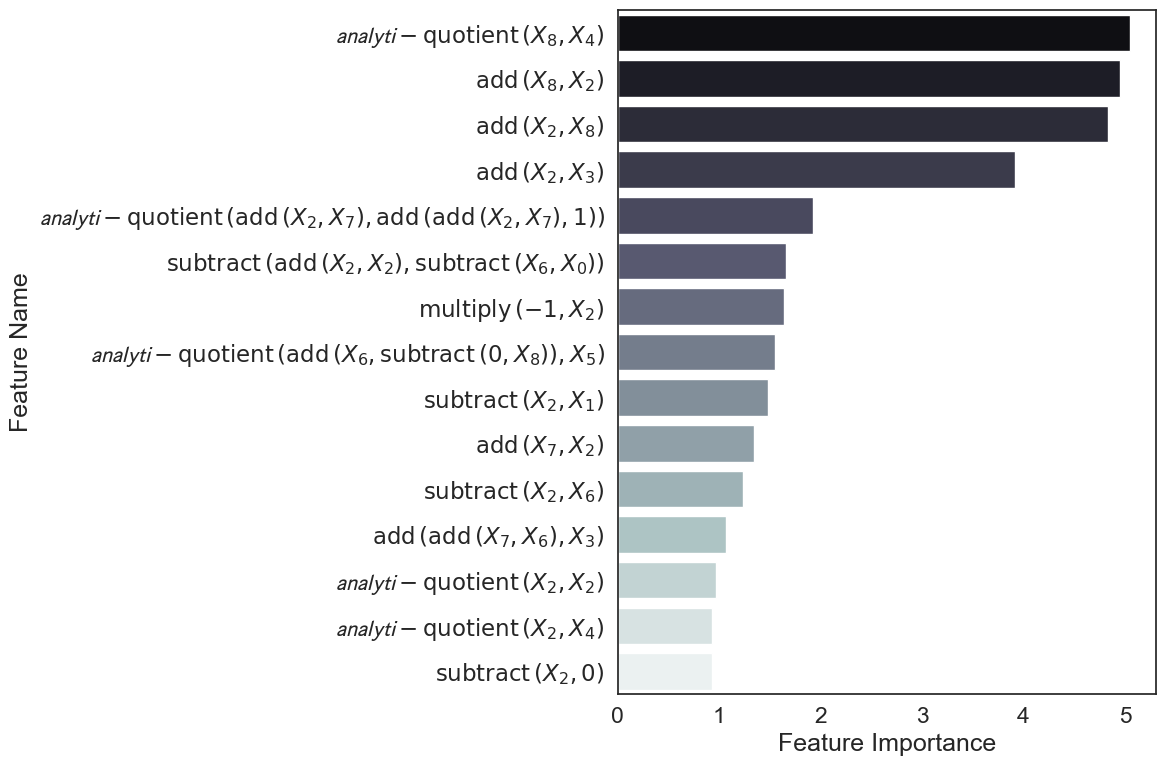

In [4]:
# Calculate and plot feature importance
feature_importance_dict = get_feature_importance(r)
plot_feature_importance(feature_importance_dict)

After generating the importance map, we can utilize these valuable features in the subsequent section and examine whether they can genuinely enhance the performance of an existing model. For simplicity, we have omitted the original features and retained only the constructed features.

In [5]:
# Synthesize new features
code_importance_dict = get_feature_importance(r, simple_version=False)
top_features = list(code_importance_dict.keys())[:len(code_importance_dict) // 2]
new_train = feature_append(r, r.x_scaler.transform(x_train), top_features, only_new_features=True)
new_test = feature_append(r, r.x_scaler.transform(x_test), top_features, only_new_features=True)

# Train a new model on synthesized features
new_r = RandomForestRegressor()
new_r.fit(new_train, y_train)
print(r2_score(y_test, new_r.predict(new_test)))

0.31144846049724884


## Further Investigation of Feature Construction
The results clearly indicate that the constructed features can effectively contribute to improved performance, highlighting the efficacy of these features. However, a more intriguing question is whether these features are limited to this specific model, or if they can be applied to other machine learning models as well. Therefore, in the subsequent section, we aim to determine if the features constructed by EF can enhance the performance of existing state-of-the-art machine learning systems.

In [6]:
regressor_list = ['RF', 'ET', 'AdaBoost', 'GBDT', 'DART', 'XGBoost', 'LightGBM', 'CatBoost']

# Normalize training and testing data
x_train, x_test = r.x_scaler.transform(x_train), r.x_scaler.transform(x_test)

# Get feature importance and select top features
code_importance_dict = get_feature_importance(r, simple_version=False)
top_features = list(code_importance_dict.keys())[:len(code_importance_dict.keys()) // 2]

# Replace the original dataset with new features
new_train = feature_append(r, x_train, top_features, only_new_features=True)
new_test = feature_append(r, x_test, top_features, only_new_features=True)

# Define regressors
regressor_dict = {
    'RF': RandomForestRegressor(n_estimators=200, n_jobs=-1),
    'ET': ExtraTreesRegressor(n_estimators=200, n_jobs=-1),
    'AdaBoost': AdaBoostRegressor(n_estimators=200),
    'GBDT': GradientBoostingRegressor(n_estimators=200),
    'DART': LGBMRegressor(n_jobs=1, n_estimators=200, boosting_type='dart',
                            xgboost_dart_mode=True),
    'XGBoost': XGBRegressor(n_jobs=1, n_estimators=200),
    'LightGBM': LGBMRegressor(n_jobs=1, n_estimators=200),
    'CatBoost': CatBoostRegressor(n_estimators=200, thread_count=1,
                                    verbose=False, allow_writing_files=False),
}

scores_base = []
scores_enhanced = []

# Train and evaluate regressors on original and new features
for regr in regressor_list:
    regressor = regressor_dict[regr]
    
    # Train on original features
    regressor.fit(x_train, y_train)
    score = r2_score(y_test, regressor.predict(x_test))
    scores_base.append((regr, score))

    # Train on new features
    regressor.fit(new_train, y_train)
    score = r2_score(y_test, regressor.predict(new_test))
    scores_enhanced.append((regr, score))

# Calculate mean scores for each algorithm
base_frame = pd.DataFrame(scores_base, columns=['algorithm', 'score'])
print(base_frame.groupby(['algorithm']).mean())

improved_frame = pd.DataFrame(scores_enhanced, columns=['algorithm', 'score'])
print(improved_frame.groupby(['algorithm']).mean())

# Calculate the improvement in scores
base_score = base_frame.groupby(['algorithm']).mean()
improved_score = improved_frame.groupby(['algorithm']).mean()
print(improved_score - base_score)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 591
[LightGBM] [Info] Number of data points in the train set: 353, number of used features: 10
[LightGBM] [Info] Start training from score 151.606232
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

## Improvement Visualization
Based on the experimental results, it can be concluded that constructive features enhance the performance of all models, with specific improvements seen in GBDT and XGBoost models. Therefore, we can assert that our method can function not only as an effective regression method for inducing a powerful regression model but also as a feature construction method that generates interpretable features and enhances the performance of existing machine learning systems. The improvement caused by constructed features is illustrated in the figure below.

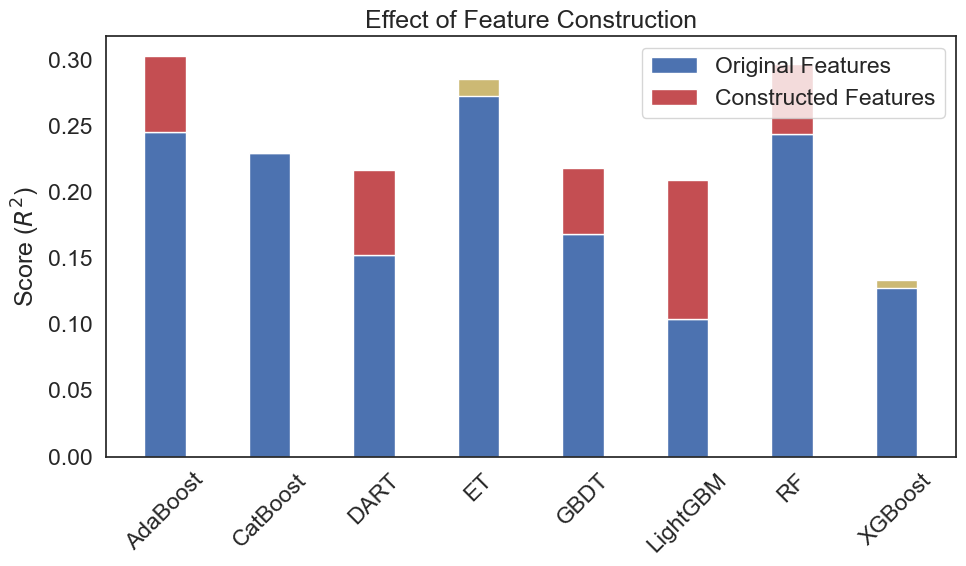

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white", font_scale=1.5)
width = 0.4
fig, ax = plt.subplots(figsize=(10, 6))

# Plot scores for original features
ax.bar(base_score.index, base_score['score'], width, label='Original Features')

# Calculate score differences
difference = improved_score['score'] - base_score['score']

# Choose bar colors based on score improvement
colors = np.where(difference > 0, 'r', 'y')

# Plot score differences for constructed features
ax.bar(base_score.index, difference, width, bottom=base_score['score'],
       label='Constructed Features', color=colors)

# Set labels and title
ax.set_ylabel('Score ($R^2$)')
ax.set_title('Effect of Feature Construction')
ax.legend()

# Format the x-axis labels
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In conclusion, we have demonstrated that our method can uncover valuable features that can enhance the performance of existing machine learning systems. However, it should be noted that even if the discovered features improve the validation score, there is a risk of overfitting. Hence, in real-world applications, it is advisable to scrutinize all utilized features to ensure the efficacy of the newly constructed model.